# MNIST QNN - Blind Quantum Computing

Este notebook demonstra como treinar um modelo de Rede Neural Quântica (QNN)
usando o Qiskit Machine Learning e circuitos gerados a partir de arquivos QASM
da base MNIST.

In [1]:
!pip install qiskit qiskit-aer qiskit-machine-learning numpy matplotlib torch scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import random
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from quantumnet.components import Network, Logger

from qiskit_aer.noise import NoiseModel, depolarizing_error
%matplotlib inline

import seaborn as sns

# Controle de Aleatoriedade e Reprodutibilidade

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Callback: envio do circuito por época
E outras funções para visualização.

In [4]:
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"[Epoch {epoch+1}] Envio concluído.")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")

def show_figure1(pict, index=0):
    try:
        pict = np.asarray(pict, dtype=np.float64).ravel()
        if pict.max() > 0:
            pict = pict / pict.max()
        size = len(pict)
        dim = int(np.ceil(np.sqrt(size)))
        padded = np.zeros((dim * dim,))
        padded[:size] = pict
        plt.imshow(padded.reshape(dim, dim), cmap="Greys")
        plt.axis('off')
        #plt.savefig(f"figura_{index}.png", bbox_inches='tight', pad_inches=0)
        #plt.close()
        plt.show()
    except Exception as e:
        print(f"Erro ao salvar figura {index}: {str(e)}")

def show_state_figure2(statevector, index=0):
    try:
        if hasattr(statevector, 'data'):
            statevector = statevector.data
        statevector = np.asarray(statevector, dtype=np.complex128)
        probs = np.abs(statevector) ** 2
            #if len(probs) < 784:
            #    padded = np.zeros(784)
            #    padded[:len(probs)] = probs
            #    probs = padded
            #show_figure(probs, index=index)
        # pega apenas os primeiros 784 valores do statevector
        pict = np.abs(statevector[:784])

        # mostra como imagem 28x28 (igual ao primeiro código)
        plt.imshow(pict.reshape(28, 28), cmap="Greys")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Erro ao processar estado {index}: {str(e)}")


def show_figure(pict: np.array, index=0, fidelity=None):
    plt.imshow(pict.reshape(28, 28), cmap="Greys")
    plt.axis('off')
    title = f"Imagem {index}"
    if fidelity is not None:
        title += f" - Fidelidade: {fidelity:.6f}"
    plt.title(f"Imagem {index}")
    plt.show()
    plt.close()

def show_state_figure(state, index=0, fidelity=None):
    state_np = np.array(state)
    pict = np.abs(state_np[:784])
    show_figure(pict, index=index, fidelity=fidelity)


def mostrar_matriz_confusao(y_true, y_pred, classes=None, title='Matriz de Confusão'):
    """
    Calcula e mostra a matriz de confusão formatada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{title}")
    print("=" * 30)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>8}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 9))
    
    # Linhas da matriz
    for i, row in enumerate(cm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>7}"
        print(row_str)
    
    return cm

def mostrar_matriz_confusao_normalizada(y_true, y_pred, classes=None, title='Matriz de Confusão Normalizada'):
    """
    Calcula e mostra a matriz de confusão normalizada
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(f"\n{title}")
    print("=" * 40)
    
    if classes is None:
        classes = [f'Classe {i}' for i in range(len(cm))]
    
    # Cabeçalho
    header = "         " + " ".join(f"{cls:>10}" for cls in classes)
    print(header)
    print(" " * 9 + "-" * (len(classes) * 11))
    
    # Linhas da matriz
    for i, row in enumerate(cm_norm):
        row_str = f"{classes[i]:<8} |"
        for val in row:
            row_str += f" {val:>9.3f}"
        print(row_str)
    
    return cm_norm

# Inicializar a rede

In [5]:
rede = Network()
rede.set_ready_topology('grade', 8, 3, 3)
Logger.activate(Logger)


Hosts inicializados
Canais inicializados
Pares EPRs adicionados


# Inicializar o Backend com Ruído

In [6]:

noise_model = NoiseModel()

error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h','x','y','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

#simulator = AerSimulator(noise_model=noise_model, shots=1024)
simulator = AerSimulator(method='statevector')


# Carregar os arquivos QASM da base MNIST.

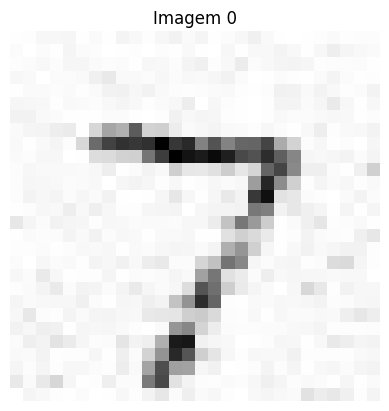

Fidelidade da imagem 0: 0.000001


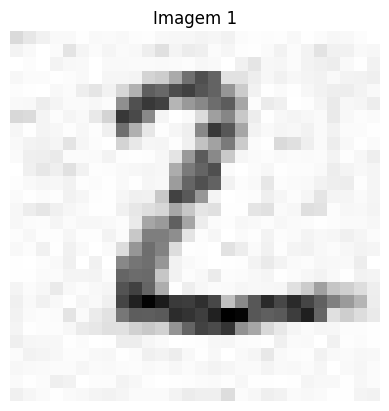

Fidelidade da imagem 1: 0.000989


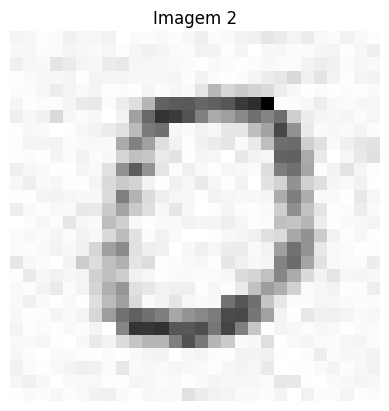

Fidelidade da imagem 2: 0.000132


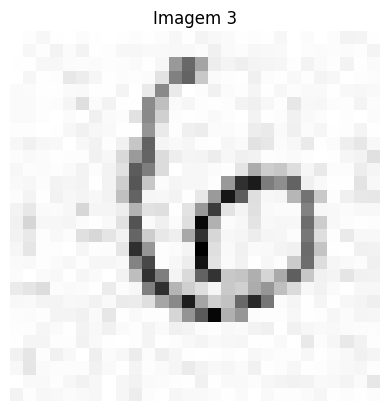

Fidelidade da imagem 3: 0.000000


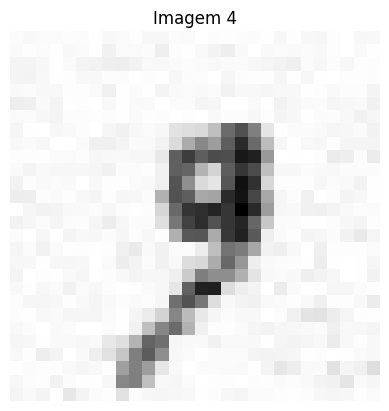

Fidelidade da imagem 4: 0.000023


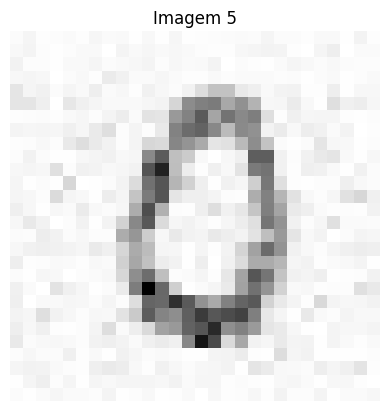

Fidelidade da imagem 5: 0.000021


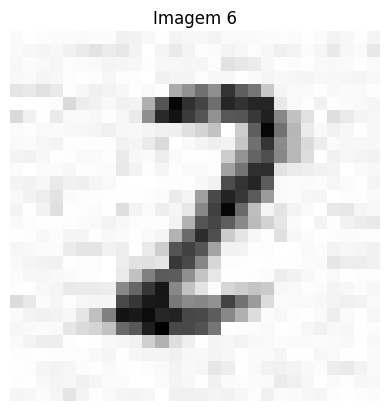

Fidelidade da imagem 6: 0.000023


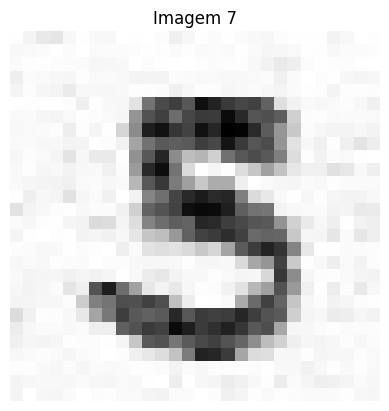

Fidelidade da imagem 7: 0.000001


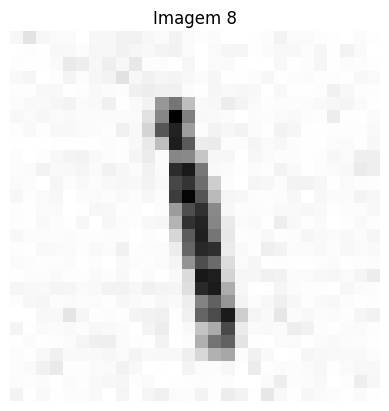

Fidelidade da imagem 8: 0.000108


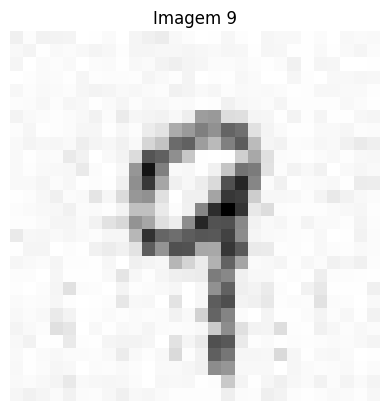

Fidelidade da imagem 9: 0.000383


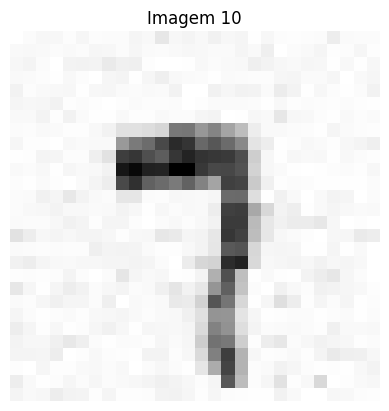

Fidelidade da imagem 10: 0.000000


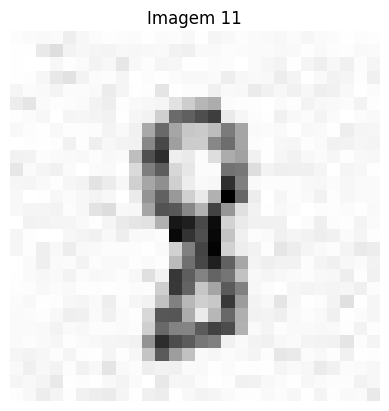

Fidelidade da imagem 11: 0.000008


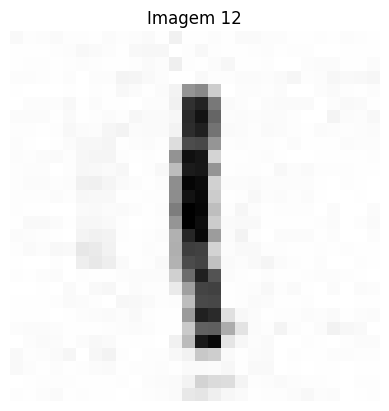

Fidelidade da imagem 12: 0.000052


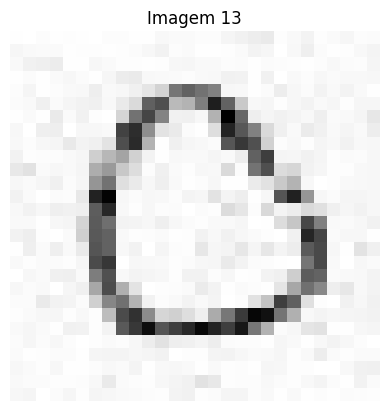

Fidelidade da imagem 13: 0.000000


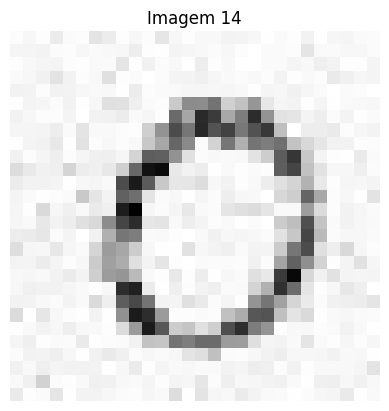

Fidelidade da imagem 14: 0.000007


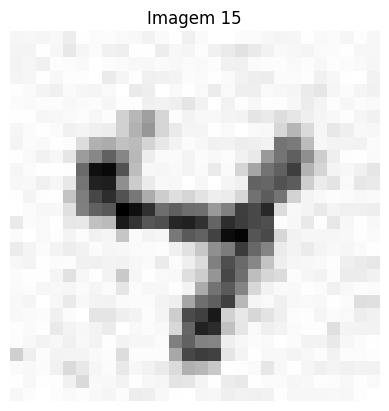

Fidelidade da imagem 15: 0.000078


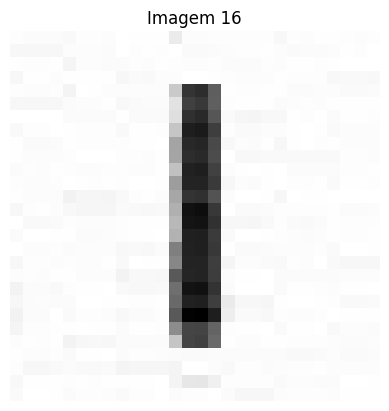

Fidelidade da imagem 16: 0.000004


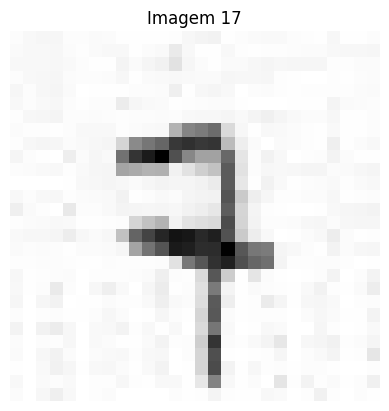

Fidelidade da imagem 17: 0.000013


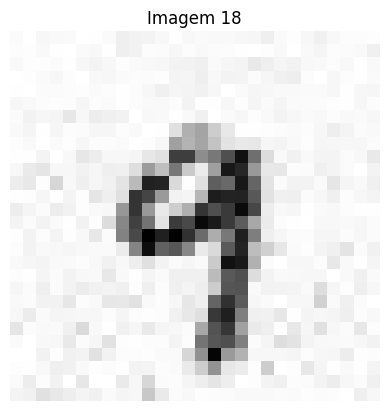

Fidelidade da imagem 18: 0.000022


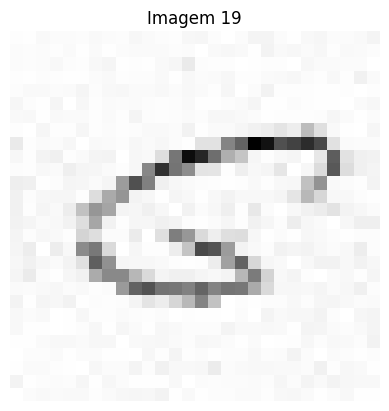

Fidelidade da imagem 19: 0.000006


In [7]:

from qiskit.quantum_info import state_fidelity, Statevector
path = "base_test_mnist_784_f90/qasm/"

file_list = sorted(os.listdir(path))[:20]
states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            state = result.data(0)['statevector']
            state_sv = Statevector(state)#
            reference_state = np.zeros(state.dim, dtype=complex)#
            reference_state[0] = 1.0#
            fidelity = state_fidelity(state_sv, reference_state)#
            #show_state_figure(state, index=i)
            show_state_figure(state_sv, index=i, fidelity=fidelity)#
            print(f"Fidelidade da imagem {i}: {fidelity:.6f}")#
            features = np.abs(state)**2
            features = features[:4]
            states.append(features)
            labels.append(0 if i < 10 else 1)
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")


        


# Divide os dados

In [8]:

X = torch.tensor(states, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X
y_train_tensor = y

num_qubits =  4
print(f"Num qubits (features) = {num_qubits}")

Num qubits (features) = 4


/tmp/ipykernel_4317/3254008697.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(states, dtype=torch.float32)


# Cria o circuito quântico (FeatureMap + Ansatz)

In [9]:

feature_map = ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

qc_base = QuantumCircuit(num_qubits)
qc_base.compose(feature_map, inplace=True)
qc_base.compose(ansatz, inplace=True)


print('Circuito pronto. Depth aproximado:', qc.depth())

Circuito pronto. Depth aproximado: 163


# EstiamdorQNN

In [10]:
observable = SparsePauliOp("Z" * num_qubits)
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc_base,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observable,
    estimator=estimator,
    input_gradients=True
)

model = TorchConnector(qnn)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


print('QNN (QuantumNeuralNetwork) configurado.')

/tmp/ipykernel_4317/2000550838.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipykernel_4317/2000550838.py:4: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


QNN (QuantumNeuralNetwork) configurado.


# Treinamento

In [11]:
print("\nINICIANDO TREINAMENTO VQC...")
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_func(torch.sigmoid(output.squeeze()), y_train_tensor.squeeze())
    loss.backward()
    optimizer.step()

    trained_weights = model.weight.detach().numpy()
    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.compose(feature_map, inplace=True)
    final_circuit.compose(ansatz.assign_parameters(trained_weights), inplace=True)

    enviar_circuito_por_epoca(
        circuito=final_circuit,
        epoch=epoch,
        num_qubits=final_circuit.num_qubits,
        circuit_depth=final_circuit.depth()
    )
    rede.start_eprs(5)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


INICIANDO TREINAMENTO VQC...


2025-08-24 13:04:41,686: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:41,687: Timeslot 1. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:41,687: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:41,688: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:41,689: Timeslot 2.
2025-08-24 13:04:41,690: Qubit 104 preparado pelo cliente 6.
2025-08-24 13:04:41,690: Qubit 367 preparado pelo cliente 6.
2025-08-24 13:04:41,691: Qubit 826 preparado pelo cliente 6.
2025-08-24 13:04:41,691: Qubit 549 preparado pelo cliente 6.
2025-08-24 13:04:41,692: Calculando rota padrão para o transporte.
2025-08-24 13:04:41,692: Timeslot 3: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:41,693: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:41,694: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:41,695: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:41,696: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 13:0

[Epoch 1] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 1] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:04:44,894: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:44,895: Timeslot 17. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:44,896: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:44,896: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:44,897: Timeslot 18.
2025-08-24 13:04:44,897: Qubit 623 preparado pelo cliente 6.
2025-08-24 13:04:44,898: Qubit 167 preparado pelo cliente 6.
2025-08-24 13:04:44,899: Qubit 947 preparado pelo cliente 6.
2025-08-24 13:04:44,899: Qubit 701 preparado pelo cliente 6.
2025-08-24 13:04:44,900: Calculando rota padrão para o transporte.
2025-08-24 13:04:44,901: Timeslot 19: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:44,901: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:44,902: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:44,902: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:44,903: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 1

[Epoch 2] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 2] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:04:48,444: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:48,445: Timeslot 33. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:48,446: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:48,446: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:48,448: Timeslot 34.
2025-08-24 13:04:48,448: Qubit 224 preparado pelo cliente 6.
2025-08-24 13:04:48,449: Qubit 521 preparado pelo cliente 6.
2025-08-24 13:04:48,450: Qubit 881 preparado pelo cliente 6.
2025-08-24 13:04:48,451: Qubit 811 preparado pelo cliente 6.
2025-08-24 13:04:48,451: Calculando rota padrão para o transporte.
2025-08-24 13:04:48,452: Timeslot 35: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:48,453: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:48,453: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:48,454: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:48,455: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 1

[Epoch 3] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 3] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:04:51,585: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:51,586: Timeslot 49. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:51,586: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:51,587: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:51,588: Timeslot 50.
2025-08-24 13:04:51,588: Qubit 891 preparado pelo cliente 6.
2025-08-24 13:04:51,589: Qubit 156 preparado pelo cliente 6.
2025-08-24 13:04:51,590: Qubit 552 preparado pelo cliente 6.
2025-08-24 13:04:51,590: Qubit 613 preparado pelo cliente 6.
2025-08-24 13:04:51,591: Calculando rota padrão para o transporte.
2025-08-24 13:04:51,592: Timeslot 51: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:51,592: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:51,593: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:51,593: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:51,594: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 1

[Epoch 4] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 4] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:04:54,929: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:54,929: Timeslot 65. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:54,930: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:54,930: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:54,931: Timeslot 66.
2025-08-24 13:04:54,932: Qubit 730 preparado pelo cliente 6.
2025-08-24 13:04:54,932: Qubit 448 preparado pelo cliente 6.
2025-08-24 13:04:54,933: Qubit 123 preparado pelo cliente 6.
2025-08-24 13:04:54,934: Qubit 346 preparado pelo cliente 6.
2025-08-24 13:04:54,934: Calculando rota padrão para o transporte.
2025-08-24 13:04:54,935: Timeslot 67: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:54,936: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:54,936: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:54,937: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:54,937: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 1

[Epoch 5] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 5] Envio concluído.
Pares EPRs adicionados
Epoch 5: Loss = 0.6934


2025-08-24 13:04:58,324: Protocolo configurado para 2 rodadas.
2025-08-24 13:04:58,325: Timeslot 81. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:04:58,325: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:04:58,326: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:04:58,326: Timeslot 82.
2025-08-24 13:04:58,327: Qubit 433 preparado pelo cliente 6.
2025-08-24 13:04:58,328: Qubit 689 preparado pelo cliente 6.
2025-08-24 13:04:58,328: Qubit 62 preparado pelo cliente 6.
2025-08-24 13:04:58,329: Qubit 819 preparado pelo cliente 6.
2025-08-24 13:04:58,329: Calculando rota padrão para o transporte.
2025-08-24 13:04:58,330: Timeslot 83: Buscando rota válida entre 6 e 0.
2025-08-24 13:04:58,330: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:04:58,331: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:04:58,332: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:04:58,333: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 13

[Epoch 6] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 6] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:05:01,464: Protocolo configurado para 2 rodadas.
2025-08-24 13:05:01,465: Timeslot 97. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:05:01,466: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:05:01,466: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:05:01,467: Timeslot 98.
2025-08-24 13:05:01,468: Qubit 168 preparado pelo cliente 6.
2025-08-24 13:05:01,468: Qubit 271 preparado pelo cliente 6.
2025-08-24 13:05:01,469: Qubit 292 preparado pelo cliente 6.
2025-08-24 13:05:01,469: Qubit 158 preparado pelo cliente 6.
2025-08-24 13:05:01,470: Calculando rota padrão para o transporte.
2025-08-24 13:05:01,470: Timeslot 99: Buscando rota válida entre 6 e 0.
2025-08-24 13:05:01,471: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:05:01,472: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:05:01,472: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:05:01,472: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 1

[Epoch 7] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 7] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:05:04,798: Protocolo configurado para 2 rodadas.
2025-08-24 13:05:04,799: Timeslot 113. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:05:04,800: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:05:04,800: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:05:04,801: Timeslot 114.
2025-08-24 13:05:04,802: Qubit 429 preparado pelo cliente 6.
2025-08-24 13:05:04,802: Qubit 957 preparado pelo cliente 6.
2025-08-24 13:05:04,803: Qubit 244 preparado pelo cliente 6.
2025-08-24 13:05:04,803: Qubit 687 preparado pelo cliente 6.
2025-08-24 13:05:04,805: Calculando rota padrão para o transporte.
2025-08-24 13:05:04,805: Timeslot 115: Buscando rota válida entre 6 e 0.
2025-08-24 13:05:04,806: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:05:04,806: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:05:04,807: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:05:04,808: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 8] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 8] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:05:09,117: Protocolo configurado para 2 rodadas.
2025-08-24 13:05:09,118: Timeslot 129. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:05:09,118: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:05:09,119: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:05:09,120: Timeslot 130.
2025-08-24 13:05:09,120: Qubit 954 preparado pelo cliente 6.
2025-08-24 13:05:09,121: Qubit 270 preparado pelo cliente 6.
2025-08-24 13:05:09,122: Qubit 760 preparado pelo cliente 6.
2025-08-24 13:05:09,122: Qubit 288 preparado pelo cliente 6.
2025-08-24 13:05:09,123: Calculando rota padrão para o transporte.
2025-08-24 13:05:09,123: Timeslot 131: Buscando rota válida entre 6 e 0.
2025-08-24 13:05:09,124: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:05:09,124: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:05:09,125: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:05:09,126: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 9] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 9] Envio concluído.
Pares EPRs adicionados


2025-08-24 13:05:12,271: Protocolo configurado para 2 rodadas.
2025-08-24 13:05:12,272: Timeslot 145. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 13:05:12,272: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 13:05:12,273: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 13:05:12,274: Timeslot 146.
2025-08-24 13:05:12,275: Qubit 558 preparado pelo cliente 6.
2025-08-24 13:05:12,275: Qubit 596 preparado pelo cliente 6.
2025-08-24 13:05:12,276: Qubit 130 preparado pelo cliente 6.
2025-08-24 13:05:12,276: Qubit 920 preparado pelo cliente 6.
2025-08-24 13:05:12,277: Calculando rota padrão para o transporte.
2025-08-24 13:05:12,278: Timeslot 147: Buscando rota válida entre 6 e 0.
2025-08-24 13:05:12,278: Rota válida encontrada: [6, 3, 0]
2025-08-24 13:05:12,279: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 13:05:12,279: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 13:05:12,280: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 10] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 10] Envio concluído.
Pares EPRs adicionados
Epoch 10: Loss = 0.6934


# Avaliação: Métricas

In [12]:

print("\nCALCULANDO MÉTRICAS...")
with torch.no_grad():
    
    preds = model(X)

    y_pred = torch.sigmoid(preds).squeeze().round().detach().numpy()
    y_true = y.squeeze().numpy()

    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
        
    # CALCULAR MATRIZ DE CONFUSÃO
    print("\n" + "="*50)
    print("MATRIZ DE CONFUSÃO")
    print("="*50)

    cm = mostrar_matriz_confusao(y_true, y_pred, classes=['Classe 0', 'Classe 1'], title='Matriz de Confusão - VQC Quântico')

    cm_norm = mostrar_matriz_confusao_normalizada(y_true, y_pred, classes=['Classe 0', 'Classe 1'], 
                                title='Matriz de Confusão Normalizada - VQC Quântico')
    tn, fp, fn, tp = cm.ravel()

    print(f"\nDetalhamento da Matriz de Confusão:")
    print(f"Verdadeiros Negativos (TN): {tn}")
    print(f"Falsos Positivos (FP): {fp}")
    print(f"Falsos Negativos (FN): {fn}")
    print(f"Verdadeiros Positivos (TP): {tp}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\nMÉTRICAS FINAIS:")
    print(f"Acurácia : {accuracy:.4f}")
    print(f"Precisão : {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nResultados Detalhados:")
    print("Entradas:", X.numpy())
    print("Saídas Previstas:", y_pred)
    print("Saídas Reais:    ", y_true)


CALCULANDO MÉTRICAS...

MATRIZ DE CONFUSÃO

Matriz de Confusão - VQC Quântico
         Classe 0 Classe 1
         ------------------
Classe 0 |       0      10
Classe 1 |       0      10

Matriz de Confusão Normalizada - VQC Quântico
           Classe 0   Classe 1
         ----------------------
Classe 0 |     0.000     1.000
Classe 1 |     0.000     1.000

Detalhamento da Matriz de Confusão:
Verdadeiros Negativos (TN): 0
Falsos Positivos (FP): 10
Falsos Negativos (FN): 0
Verdadeiros Positivos (TP): 10

MÉTRICAS FINAIS:
Acurácia : 0.5000
Precisão : 0.5000
Recall   : 1.0000
F1 Score : 0.6667

Resultados Detalhados:
Entradas: [[6.4658144e-07 4.5838110e-06 1.0378848e-04 9.1634029e-05]
 [9.8912814e-04 4.7774921e-04 2.2803224e-04 4.1500109e-05]
 [1.3160148e-04 7.9385463e-05 4.7750509e-06 2.0419990e-05]
 [1.1637729e-08 7.1839950e-06 9.0049980e-05 1.9517349e-06]
 [2.2996908e-05 5.4380402e-05 3.3384269e-05 3.4350618e-05]
 [2.1203559e-05 1.5523344e-04 7.5676571e-06 8.9265286e-06]
 [2.3067192e-

# Gráfico

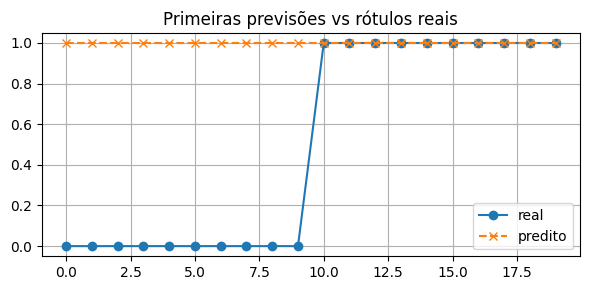

In [13]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_true, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()